In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift, fft2, ifft2, ifftn
from skimage.data import shepp_logan_phantom
from skimage.transform import resize
from tqdm import tqdm
from numba import cuda
import cmath
from skimage.transform import resize
import sigpy as sp


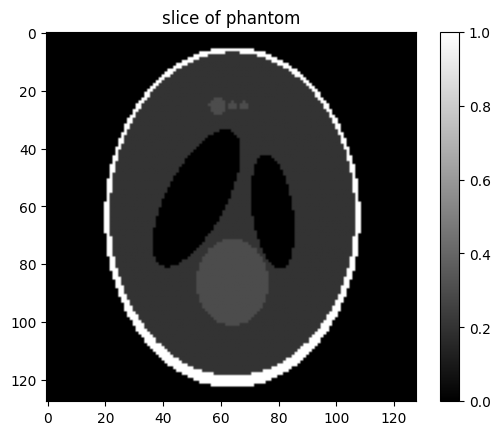

In [3]:
N_spins_x = 128
N_spins_y = 128
N_spins_z = 128


# Generate a 3D phantom with size 128x128x128
phantom = sp.shepp_logan((N_spins_x, N_spins_y, N_spins_z))
phantom = phantom.astype(dtype=np.complex128)

plt.title('slice of phantom')
plt.imshow(np.abs(phantom[N_spins_x // 2, :, :]), cmap='gray')
plt.colorbar()
plt.show()

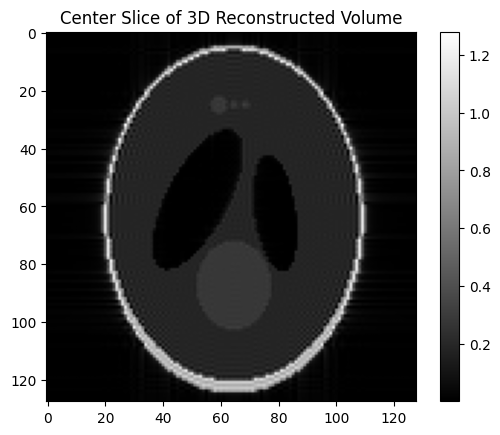

In [4]:

phantom_flat = phantom.flatten()

# Gyromagnetic ratio, gradient scale, etc. (simple 3D extension)
gamma = 42.58e6  # Hz/T
g_mult = 10
G0 = 0.004755753 * g_mult  # Base gradient strength in T/m
tau = 2e-3                 # seconds
timex = np.linspace(-tau/2, tau/2, N_spins_x)
timey = np.linspace(-tau/2, tau/2, N_spins_y)
timez = np.linspace(-tau/2, tau/2, N_spins_z)


# We'll define all three gradient waveforms as the same shape for illustration:
Gx_values = timex * G0
Gy_values = timey * G0
Gz_values = timez * G0

# Convert to k-space wave numbers
kx_values = gamma * Gx_values
ky_values = gamma * Gy_values
kz_values = gamma * Gz_values

# Create a 3D mesh of kx, ky, kz, then flatten
kx_grid, ky_grid, kz_grid = np.meshgrid(kx_values, ky_values, kz_values, indexing='ij')
kx_values_flat = kx_grid.flatten()  # length = N_spins^3
ky_values_flat = ky_grid.flatten()  # length = N_spins^3
kz_values_flat = kz_grid.flatten()  # length = N_spins^3

# Define a 3D spatial grid (x, y, z)
FOV = 0.2  # meters
x_1d = np.linspace(-FOV/2, FOV/2, N_spins_x)
y_1d = np.linspace(-FOV/2, FOV/2, N_spins_y)
z_1d = np.linspace(-FOV/2, FOV/2, N_spins_z)

x_grid, y_grid, z_grid = np.meshgrid(x_1d, y_1d, z_1d, indexing='ij')
x_values_flat = x_grid.flatten()  # length = N_spins^3
y_values_flat = y_grid.flatten()  # length = N_spins^3
z_values_flat = z_grid.flatten()  # length = N_spins^3

# Total number of voxels and total number of k-space points
N_voxels = N_spins_x*N_spins_y*N_spins_z
N_kspace_pts = N_spins_x*N_spins_y*N_spins_z

# --------------------------------------------------------------------
# 2) Define the CUDA Kernel for 3D K-space Accumulation
# --------------------------------------------------------------------
@cuda.jit
def fill_kspace_3d_cuda(k_space_out,
                        phantom_vec,
                        x_img,
                        y_img,
                        z_img,
                        kx_vals,
                        ky_vals,
                        kz_vals,
                        n_voxels):
    """
    Each thread computes one 3D k-space value:
       k_space_out[idx] = sum_{p} [ phantom_vec[p] * exp(-i * (kx*x_p + ky*y_p + kz*z_p)) ]
    """
    idx = cuda.grid(1)  # 1D thread index
    if idx < n_voxels:
        kx = kx_vals[idx]
        ky = ky_vals[idx]
        kz = kz_vals[idx]

        accum = 0.0 + 0.0j
        for p in range(n_voxels):
            phase = -1j * (kx * x_img[p] + ky * y_img[p] + kz * z_img[p])
            accum += phantom_vec[p] * cmath.exp(phase)

        k_space_out[idx] = accum

# --------------------------------------------------------------------
# 3) Allocate Arrays & Copy to GPU
# --------------------------------------------------------------------
k_space_flat = np.zeros(N_kspace_pts, dtype=np.complex128)  # host result array

d_k_space_out = cuda.to_device(k_space_flat)
d_phantom_vec = cuda.to_device(phantom_flat)
d_x_img       = cuda.to_device(x_values_flat)
d_y_img       = cuda.to_device(y_values_flat)
d_z_img       = cuda.to_device(z_values_flat)
d_kx_vals     = cuda.to_device(kx_values_flat)
d_ky_vals     = cuda.to_device(ky_values_flat)
d_kz_vals     = cuda.to_device(kz_values_flat)

# --------------------------------------------------------------------
# 4) Launch the Kernel
# --------------------------------------------------------------------
threadsperblock = 128
blockspergrid = (N_kspace_pts + threadsperblock - 1) // threadsperblock

fill_kspace_3d_cuda[blockspergrid, threadsperblock](
    d_k_space_out,
    d_phantom_vec,
    d_x_img, d_y_img, d_z_img,
    d_kx_vals, d_ky_vals, d_kz_vals,
    N_voxels
)

cuda.synchronize()

# --------------------------------------------------------------------
# 5) Copy Result Back and Reshape
# --------------------------------------------------------------------
k_space_flat_gpu = d_k_space_out.copy_to_host()
k_space_3d = k_space_flat_gpu.reshape(N_spins_x, N_spins_y, N_spins_z)

# --------------------------------------------------------------------
# 6) 3D Inverse FFT to Reconstruct the Volume
# --------------------------------------------------------------------
reconstructed_3d = ifftn(k_space_3d)
reconstructed_3d_shifted = fftshift(reconstructed_3d)

# We'll plot a single slice to visualize, e.g., the middle slice
mid_slice = N_spins_x  // 2
slice_image = reconstructed_3d_shifted[mid_slice, :, :]

plt.figure()
plt.imshow(np.abs(slice_image), cmap='gray')
plt.title('Center Slice of 3D Reconstructed Volume')
plt.colorbar()
plt.show()


100%|██████████| 5/5 [11:43<00:00, 140.67s/it]


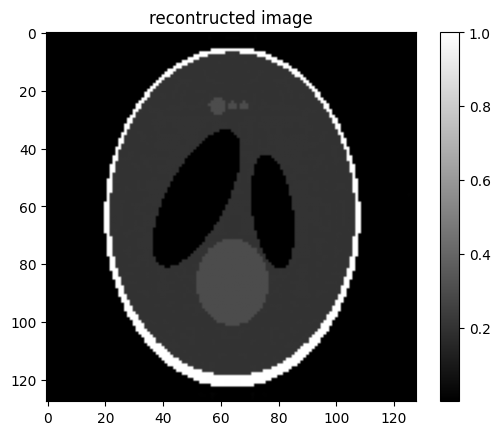

In [9]:


# ---------------------------------------------------------
# 1) Define CUDA Kernels for Forward (E) & Adjoint (E^H)
# ---------------------------------------------------------
@cuda.jit
def E_forward_kernel(x_dev,
                     kx_dev, ky_dev, kz_dev,
                     xvals_dev, yvals_dev, zvals_dev,
                     out_dev,
                     N_voxels):
    """
    Each thread computes one k-space point:
       out_dev[i] = sum_j [ x_dev[j] * exp(-i * (kx[i]*x_j + ky[i]*y_j + kz[i]*z_j)) ]
    i in [0..N_voxels-1], j in [0..N_voxels-1].
    """
    i = cuda.grid(1)
    if i < out_dev.size:
        kx = kx_dev[i]
        ky = ky_dev[i]
        kz = kz_dev[i]

        accum = 0.0 + 0.0j
        for j in range(N_voxels):
            phase = -1j * (kx*xvals_dev[j] + ky*yvals_dev[j] + kz*zvals_dev[j])
            accum += x_dev[j] * cmath.exp(phase)

        out_dev[i] = accum


@cuda.jit
def E_adj_kernel(y_dev,
                 kx_dev, ky_dev, kz_dev,
                 xvals_dev, yvals_dev, zvals_dev,
                 out_dev,
                 N_voxels):
    """
    Each thread computes one image voxel for E^H:
       out_dev[j] = sum_i [ y_dev[i] * exp(+i * (kx[i]*x_j + ky[i]*y_j + kz[i]*z_j)) ]
    j in [0..N_voxels-1], i in [0..N_voxels-1].
    """
    j = cuda.grid(1)
    if j < out_dev.size:
        xj = xvals_dev[j]
        yj = yvals_dev[j]
        zj = zvals_dev[j]

        accum = 0.0 + 0.0j
        for i in range(N_voxels):
            kx = kx_dev[i]
            ky = ky_dev[i]
            kz = kz_dev[i]
            phase = 1j * (kx*xj + ky*yj + kz*zj)
            accum += y_dev[i] * cmath.exp(phase)

        out_dev[j] = accum

# ---------------------------------------------------------
# 2) GPU Wrappers for E-forward and E-adjoint
# ---------------------------------------------------------
def E_forward_gpu(x_host,
                  kx_values_flat, ky_values_flat, kz_values_flat,
                  x_values_flat, y_values_flat, z_values_flat,
                  N_voxels,
                  threadsperblock=128):
    """
    x_host (CPU) -> E_forward_kernel -> returns k-space array on CPU
    """
    # Move data to device
    x_dev = cuda.to_device(x_host)
    kx_dev = cuda.to_device(kx_values_flat)
    ky_dev = cuda.to_device(ky_values_flat)
    kz_dev = cuda.to_device(kz_values_flat)
    xv_dev = cuda.to_device(x_values_flat)
    yv_dev = cuda.to_device(y_values_flat)
    zv_dev = cuda.to_device(z_values_flat)

    # Output array on device
    out_dev = cuda.device_array(N_voxels, dtype=np.complex128)

    # Grid
    blockspergrid = (N_voxels + threadsperblock - 1) // threadsperblock
    # Launch kernel
    E_forward_kernel[blockspergrid, threadsperblock](
        x_dev,
        kx_dev, ky_dev, kz_dev,
        xv_dev, yv_dev, zv_dev,
        out_dev,
        N_voxels
    )
    cuda.synchronize()

    # Copy back
    return out_dev.copy_to_host()


def E_adj_gpu(y_host,
              kx_values_flat, ky_values_flat, kz_values_flat,
              x_values_flat, y_values_flat, z_values_flat,
              N_voxels,
              threadsperblock=128):
    """
    y_host (CPU) -> E_adj_kernel -> returns image array on CPU
    """
    # Move data to device
    y_dev = cuda.to_device(y_host)
    kx_dev = cuda.to_device(kx_values_flat)
    ky_dev = cuda.to_device(ky_values_flat)
    kz_dev = cuda.to_device(kz_values_flat)
    xv_dev = cuda.to_device(x_values_flat)
    yv_dev = cuda.to_device(y_values_flat)
    zv_dev = cuda.to_device(z_values_flat)

    # Output array on device
    out_dev = cuda.device_array(N_voxels, dtype=np.complex128)

    # Grid
    blockspergrid = (N_voxels + threadsperblock - 1) // threadsperblock
    # Launch kernel
    E_adj_kernel[blockspergrid, threadsperblock](
        y_dev,
        kx_dev, ky_dev, kz_dev,
        xv_dev, yv_dev, zv_dev,
        out_dev,
        N_voxels
    )
    cuda.synchronize()

    # Copy back
    return out_dev.copy_to_host()


# ---------------------------------------------------------
# 3) Conjugate Gradient Solver that uses E on the fly
# ---------------------------------------------------------
def cg_mri_reconstruction_operator_cuda(
    kx_values_flat, ky_values_flat, kz_values_flat,
    x_values_flat, y_values_flat, z_values_flat,
    k_space_flat,
    N_spins,
    tol=1e-8,
    max_iter=10
):
    """
    3D Conjugate Gradient to solve (E^H E)x = E^H b,
    using your original variable names:
      - kx_values_flat, etc. (size N_spins^3)
      - x_values_flat, etc. (size N_spins^3)
      - k_space_flat (size N_spins^3)
      - N_spins^3 = N_voxels
    Returns 3D array of shape (N_spins, N_spins, N_spins).
    """

    N_voxels = N_spins**3

    # Function A(x) = E^H (E x)
    def A_func(x_vector):
        # Forward
        Ex = E_forward_gpu(
            x_vector,
            kx_values_flat, ky_values_flat, kz_values_flat,
            x_values_flat, y_values_flat, z_values_flat,
            N_voxels
        )
        # Adjoint
        return E_adj_gpu(
            Ex,
            kx_values_flat, ky_values_flat, kz_values_flat,
            x_values_flat, y_values_flat, z_values_flat,
            N_voxels
        )

    # RHS = E^H b
    rhs = E_adj_gpu(
        k_space_flat,
        kx_values_flat, ky_values_flat, kz_values_flat,
        x_values_flat, y_values_flat, z_values_flat,
        N_voxels
    )

    # Initialize CG
    x = np.zeros(N_voxels, dtype=np.complex128)
    r = rhs - A_func(x)
    p = r.copy()
    r_old_norm = np.vdot(r, r).real

    for iteration in tqdm(range(max_iter)):
        Ap = A_func(p)
        denom = np.vdot(p, Ap).real
        if denom == 0.00:
            print("Denominator is zero; There is an error")
            break
        alpha = r_old_norm / denom
        x = x + alpha * p
        r = r - alpha * Ap
        r_new_norm = np.vdot(r, r).real

        if np.sqrt(r_new_norm) < tol:
            print(f"CG converged in {iteration+1} iterations.")
            break

        beta = r_new_norm / r_old_norm
        p = r + beta * p
        r_old_norm = r_new_norm

    # Reshape final solution back to 3D volume
    reconstructed_3d = x.reshape(N_spins, N_spins, N_spins)
    return reconstructed_3d


# ---------------------------------------------------------
# 4) Putting it all together / Example usage
# ---------------------------------------------------------
if __name__ == "__main__":


    # For demonstration, let's suppose the code snippet at the top
    # was run. That means we have:
    #   k_space_flat_gpu = d_k_space_out.copy_to_host() => "k_space_flat"
    #   (Or if you generated data by fill_kspace_3d_cuda, that is your
    #    measured/ synthetic k-space data.)
    #
    # Now we simply call the CG solver:
    reconstructed_3d = cg_mri_reconstruction_operator_cuda(
        kx_values_flat, ky_values_flat, kz_values_flat,
        x_values_flat, y_values_flat, z_values_flat,
        k_space_flat_gpu,
        N_spins_x,
        tol=1e-6,
        max_iter=5
    )

    # Show a slice of the final reconstruction

    plt.figure()
    plt.imshow(np.abs(reconstructed_3d[64, :, :]), cmap='grey')
    plt.colorbar()
    plt.title('recontructed image')
    plt.show()
